Load backtest object

In [266]:
import pickle

class backtest_object:
  def __init__(self,grid_search, X, y, best_estim_preds, final_model):
    self.grid_search = grid_search
    self.X = X
    self.y = y
    self.best_estim_preds = best_estim_preds
    self.final_model = best_gbm

def Acc_Score(y_true,y_pred):
    global ys
    ys.append(y_pred)
    acc = accuracy_score(y_true, y_pred)    
    return acc

# Load the object from the file
with open('backtest_object_10Y_UST_v1.pkl', 'rb') as file:
    backtest_object_10Y_UST_v1 = pickle.load(file)

In [267]:
# Print the best hyperparameters
print("Best Hyperparameters:", backtest_object_10Y_UST_v1.grid_search.best_params_)
print(f'Accuracy of the Best Hyperparameters: {backtest_object_10Y_UST_v1.grid_search.best_score_:.4f}')


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 50, 'subsample': 1}
Accuracy of the Best Hyperparameters: 0.6235


In [268]:
X = backtest_object_10Y_UST_v1.X
y = backtest_object_10Y_UST_v1.y
y_preds = backtest_object_10Y_UST_v1.best_estim_preds

In [269]:
y.tail()

Date
2023-09-03    SHORT
2023-09-10    SHORT
2023-09-17    SHORT
2023-09-24    SHORT
2023-10-01    SHORT
Name: YIELD_weekly_percent_change_10 YR_lead, dtype: object

In [270]:
import pandas as pd
# Merge or join with the existing merged_data
y_df = pd.DataFrame(y[(len(y) - len(y_preds)):,])
y_df['y_pred'] = y_preds

In [271]:
import sqlite3

# Create a connection to the database
conn = sqlite3.connect("Treasury_Yields_data.db" )

# Get a list of all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()

# Read the table into a DataFrame
query = f"SELECT Date, `10 YR` FROM YIELD_weekly_percent_change;"
T10y_df = pd.read_sql_query(query, conn, index_col='Date', parse_dates='Date')

# Read the table into a DataFrame
query = f"SELECT Date, `10 YR` FROM YIELD_weekly;"
T10y_df_lvl = pd.read_sql_query(query, conn, index_col='Date', parse_dates='Date')
T10y_df_lvl = T10y_df_lvl.rename(columns={'10 YR': '10 YR Lvl'})

In [272]:
merged_data = pd.merge(y_df, T10y_df, on='Date' ,how='left')
merged_data = pd.merge(merged_data, T10y_df_lvl, on='Date' ,how='left')

In [273]:
merged_data.tail()


,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl
Date,,,,
2023-09-03,SHORT,SHORT,-0.016471,4.18
2023-09-10,SHORT,SHORT,0.019139,4.26
2023-09-17,SHORT,LONG,0.016432,4.33
2023-09-24,SHORT,LONG,0.025404,4.44
2023-10-01,SHORT,LONG,0.033784,4.59


In [274]:
merged_data['For0'] = merged_data['y_pred'].shift(periods=1)
merged_data.tail(10)

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0
Date,,,,,
2023-07-30,SHORT,SHORT,0.031250,3.96,SHORT
2023-08-06,SHORT,LONG,0.022727,4.05,SHORT
2023-08-13,SHORT,SHORT,0.027160,4.16,LONG
2023-08-20,LONG,SHORT,0.024038,4.26,SHORT
2023-08-27,LONG,LONG,-0.002347,4.25,SHORT
2023-09-03,SHORT,SHORT,-0.016471,4.18,LONG
2023-09-10,SHORT,SHORT,0.019139,4.26,SHORT
2023-09-17,SHORT,LONG,0.016432,4.33,SHORT
2023-09-24,SHORT,LONG,0.025404,4.44,LONG


In [275]:
import numpy as np
merged_data['Pos'] = np.where(merged_data['For0'] == 'LONG' , 1, -1)
merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos
Date,,,,,,
2023-09-03,SHORT,SHORT,-0.016471,4.18,LONG,1
2023-09-10,SHORT,SHORT,0.019139,4.26,SHORT,-1
2023-09-17,SHORT,LONG,0.016432,4.33,SHORT,-1
2023-09-24,SHORT,LONG,0.025404,4.44,LONG,1
2023-10-01,SHORT,LONG,0.033784,4.59,LONG,1


In [276]:
merged_data['Turnover'] = 1

merged_data['Turnover'] = np.where(merged_data['Pos'] == merged_data['Pos'].shift(periods=1),0,2)

merged_data['Turnover'][1] = 1


C:\Users\dstoc\AppData\Local\Temp\ipykernel_20632\3329850808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Turnover'][1] = 1


In [277]:
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover
Date,,,,,,,
2018-12-02,LONG,SHORT,-0.013115,3.01,None,-1,2
2018-12-09,SHORT,LONG,-0.053156,2.85,SHORT,-1,1
2018-12-16,LONG,SHORT,0.014035,2.89,LONG,1,2
2018-12-23,LONG,LONG,-0.034602,2.79,SHORT,-1,2
2018-12-30,LONG,LONG,-0.025090,2.72,LONG,1,2


In [278]:
mat = 10
merged_data['Approx. Duration'] = (1/(merged_data['10 YR Lvl']/100)) * ( 1 - (1 / ( 1 + 0.5 * (merged_data['10 YR Lvl']/100)) ** (2 * mat)))
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration
Date,,,,,,,,
2018-12-02,LONG,SHORT,-0.013115,3.01,None,-1,2,8.580090
2018-12-09,SHORT,LONG,-0.053156,2.85,SHORT,-1,1,8.648123
2018-12-16,LONG,SHORT,0.014035,2.89,LONG,1,2,8.631043
2018-12-23,LONG,LONG,-0.034602,2.79,SHORT,-1,2,8.673835
2018-12-30,LONG,LONG,-0.025090,2.72,LONG,1,2,8.703970


=(2/(B3/100)^2)*(1-(1/(1+B3/200)^(20)))
-20/((B3/100)*(1+B3/200)^(21))

In [279]:
merged_data['Approx. Convexity'] = (2/((merged_data['10 YR Lvl']/100)**2)) * (1 - (1/(1+0.5*(merged_data['10 YR Lvl']/100))**(2*mat))) - (2*mat) / ((merged_data['10 YR Lvl']/100)*(1+0.5*(merged_data['10 YR Lvl']/100))**(2*mat+1))
merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity
Date,,,,,,,,,
2023-09-03,SHORT,SHORT,-0.016471,4.18,LONG,1,2,8.105151,77.917074
2023-09-10,SHORT,SHORT,0.019139,4.26,SHORT,-1,2,8.074071,77.485810
2023-09-17,SHORT,LONG,0.016432,4.33,SHORT,-1,0,8.047016,77.110788
2023-09-24,SHORT,LONG,0.025404,4.44,LONG,1,2,8.004766,76.525832
2023-10-01,SHORT,LONG,0.033784,4.59,LONG,1,0,7.947669,75.736675


In [280]:
(1 + (merged_data['10 YR Lvl'].iloc[ 1] / 100))**(1 / 52) - 1

0.0005405581664528203

=-Dur3*(Yield3/100-Yield2/100)+0.5*Conv3*(yield3/100-yield2/100)^2+((1+yield2/100)^(1/52)-1)
duration, convexity, and carry included

https://datarepository.eur.nl/articles/dataset/Data_Treasury_Bond_Return_Data_Starting_in_1962/8152748?file=38737083

In [281]:
merged_data['ret'] = 0
# Calculate 'ret' for each row
for i in range(1, len(merged_data)):
    merged_data['ret'].iloc[i] = (-merged_data['Approx. Duration'].iloc[i] * (
            (merged_data['10 YR Lvl'].iloc[i] / 100) - (merged_data['10 YR Lvl'].iloc[i - 1] / 100)
        )) + (0.5 * merged_data['Approx. Convexity'].iloc[i] * (
            (merged_data['10 YR Lvl'].iloc[i] / 100) - (merged_data['10 YR Lvl'].iloc[i - 1] / 100)
        )**2) + (
            (1 + (merged_data['10 YR Lvl'].iloc[i - 1] / 100))**(1 / 52) - 1
        )

C:\Users\dstoc\AppData\Local\Temp\ipykernel_20632\2391953352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['ret'].iloc[i] = (-merged_data['Approx. Duration'].iloc[i] * (


In [282]:
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret
Date,,,,,,,,,,
2018-12-02,LONG,SHORT,-0.013115,3.01,None,-1,2,8.580090,84.563015,0.000000
2018-12-09,SHORT,LONG,-0.053156,2.85,SHORT,-1,1,8.648123,85.523354,0.014517
2018-12-16,LONG,SHORT,0.014035,2.89,LONG,1,2,8.631043,85.282061,-0.002905
2018-12-23,LONG,LONG,-0.034602,2.79,SHORT,-1,2,8.673835,85.886815,0.009265
2018-12-30,LONG,LONG,-0.025090,2.72,LONG,1,2,8.703970,86.313173,0.006643


In [283]:
#-merged_data['Approx. Duration'][row]*((merged_data['10 YR Lvl'][row]/100)-(merged_data['10 YR Lvl'][row - 1]/100))+0.5*merged_data['Approx. Convexity'][row]*((merged_data['10 YR Lvl'][row]/100)-(merged_data['10 YR Lvl'][row - 1]/100))^2+((1+(merged_data['10 YR Lvl'][row - 1]/100))^(1/52)-1)

In [284]:
merged_data = merged_data[1:] # drpo first row with no prediction
merged_data['trade ret'] = merged_data['ret'] * merged_data['Pos'] - (merged_data['Turnover'] * .0009)
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret,trade ret
Date,,,,,,,,,,,
2018-12-09,SHORT,LONG,-0.053156,2.85,SHORT,-1,1,8.648123,85.523354,0.014517,-0.015417
2018-12-16,LONG,SHORT,0.014035,2.89,LONG,1,2,8.631043,85.282061,-0.002905,-0.004705
2018-12-23,LONG,LONG,-0.034602,2.79,SHORT,-1,2,8.673835,85.886815,0.009265,-0.011065
2018-12-30,LONG,LONG,-0.025090,2.72,LONG,1,2,8.703970,86.313173,0.006643,0.004843
2019-01-06,SHORT,SHORT,-0.018382,2.67,LONG,1,0,8.725586,86.619252,0.004890,0.004890


In [285]:
merged_data['cumulative_ret'] = (merged_data['trade ret'] +1).cumprod()
merged_data['static_long_ret'] = (merged_data['ret'] + 1).cumprod()
merged_data['static_short_ret'] = (merged_data['ret']*-1 + 1).cumprod()
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret,trade ret,cumulative_ret,static_long_ret,static_short_ret
Date,,,,,,,,,,,,,,
2018-12-09,SHORT,LONG,-0.053156,2.85,SHORT,-1,1,8.648123,85.523354,0.014517,-0.015417,0.984583,1.014517,0.985483
2018-12-16,LONG,SHORT,0.014035,2.89,LONG,1,2,8.631043,85.282061,-0.002905,-0.004705,0.979951,1.011570,0.988346
2018-12-23,LONG,LONG,-0.034602,2.79,SHORT,-1,2,8.673835,85.886815,0.009265,-0.011065,0.969108,1.020942,0.979189
2018-12-30,LONG,LONG,-0.025090,2.72,LONG,1,2,8.703970,86.313173,0.006643,0.004843,0.973801,1.027724,0.972684
2019-01-06,SHORT,SHORT,-0.018382,2.67,LONG,1,0,8.725586,86.619252,0.004890,0.004890,0.978563,1.032750,0.967928


In [286]:

merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret,trade ret,cumulative_ret,static_long_ret,static_short_ret
Date,,,,,,,,,,,,,,
2023-09-03,SHORT,SHORT,-0.016471,4.18,LONG,1,2,8.105151,77.917074,0.006493,0.004693,1.363420,1.011987,0.960059
2023-09-10,SHORT,SHORT,0.019139,4.26,SHORT,-1,2,8.074071,77.485810,-0.005647,0.003847,1.368665,1.006273,0.965481
2023-09-17,SHORT,LONG,0.016432,4.33,SHORT,-1,0,8.047016,77.110788,-0.004811,0.004811,1.375250,1.001431,0.970126
2023-09-24,SHORT,LONG,0.025404,4.44,LONG,1,2,8.004766,76.525832,-0.007943,-0.009743,1.361851,0.993476,0.977832
2023-10-01,SHORT,LONG,0.033784,4.59,LONG,1,0,7.947669,75.736675,-0.011001,-0.011001,1.346870,0.982548,0.988589


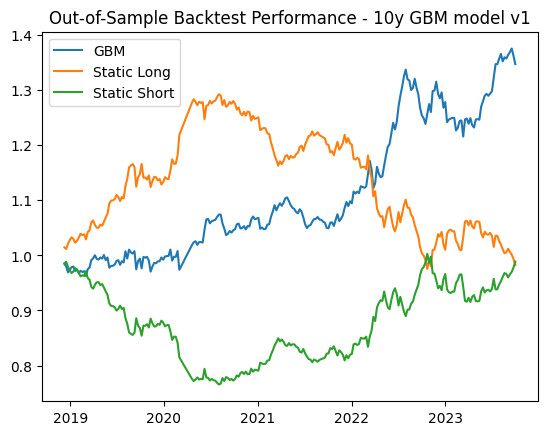

In [318]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(merged_data.index, merged_data['cumulative_ret'], label='GBM')
plt.plot(merged_data.index, merged_data['static_long_ret'], label='Static Long')
plt.plot(merged_data.index, merged_data['static_short_ret'], label='Static Short')
plt.title('Out-of-Sample Backtest Performance - 10y GBM model v1')
plt.legend()

In [375]:
cum_ret_gbm = merged_data['cumulative_ret'][-1]
cum_ret_static_long = merged_data['static_long_ret'][-1]
cum_ret_static_short = merged_data['static_short_ret'][-1]

print(f'Out-of-Sample Cumulative Return of GBM: {cum_ret_gbm:.4f}')
print(f'Out-of-Sample Cumulative Return of Static Long: {cum_ret_static_long:.4f}')
print(f'Out-of-Sample Cumulative Return of Static Short: {cum_ret_static_short:.4f}')
import pandas as pd
import numpy as np


returns_df = merged_data.copy()

# Calculate drawdowns
returns_df['Peak'] = returns_df['cumulative_ret'].cummax()
returns_df['Drawdown'] = (returns_df['cumulative_ret'] / returns_df['Peak']) - 1

# # Find drawdowns
# drawdowns = returns_df[returns_df['Drawdown'] < 0]

# Calculate drawdown metrics
# Initialize lists to store drawdown metrics
drawdown_lengths = []
drawdown_depths = []
drawdown_dates = []

current_length = 0
current_depth = 0
current_start_date = None

for date, drawdown in zip(returns_df.index, returns_df['Drawdown']):
    if drawdown < 0:
        current_length += 1
        current_depth = min(current_depth, drawdown)
        if current_start_date is None:
            current_start_date = date
    else:
        if current_length > 0:
            drawdown_lengths.append(current_length)
            drawdown_depths.append(current_depth)
            drawdown_dates.append(current_start_date)
            current_length = 0
            current_depth = 0
            current_start_date = None
    

if current_length > 0:
    drawdown_lengths.append(current_length)
    drawdown_depths.append(current_depth)
    drawdown_dates.append(current_start_date)

# Calculate average length of drawdowns
average_drawdown_length = np.mean(drawdown_lengths)

# Identify the date, length, and depth of the longest drawdown
longest_drawdown_index = np.argmax(drawdown_lengths)
longest_drawdown_date = drawdown_dates[longest_drawdown_index]
longest_drawdown_length = drawdown_lengths[longest_drawdown_index]
longest_drawdown_depth = drawdown_depths[longest_drawdown_index]

print("Average Drawdown Length:", average_drawdown_length, "weeks")
print("Date of the Longest Drawdown:", longest_drawdown_date)
print("Length of the Longest Drawdown:", longest_drawdown_length, "weeks")
print(f"Depth of the Longest Drawdown: {longest_drawdown_depth:.4f}")

# Calculate Sortino ratio
risk_free_rate = 0.00  # replace with the actual risk-free rate
downside_returns = returns_df['trade ret'][returns_df['trade ret'] < 0]
downside_deviation = np.std(downside_returns)

sortino_ratio = (np.mean(returns_df['trade ret']) - risk_free_rate) / downside_deviation
print(f"Sortino Ratio: {sortino_ratio:.4f}")

# Calculate Sharpe ratio
sharpe_ratio = (np.mean(returns_df['trade ret']) - risk_free_rate) / np.std(returns_df['trade ret'])
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Calculate Information Ratio
benchmark_returns = returns_df['ret'] # static long
excess_returns = returns_df['trade ret'] - benchmark_returns
information_ratio = np.mean(excess_returns) / np.std(excess_returns)
print(f"Information Ratio: {information_ratio:.4f}")

Hit_rate = returns_df['trade ret'][returns_df['trade ret'] > 0].count() / returns_df['trade ret'].count()
print(f'Hit Rate: {Hit_rate:.4f}')

subset_df = returns_df[returns_df['Pos'] == -1 ]
subset_df["short_cum_ret"] = (subset_df['trade ret'] +1).cumprod()
cum_ret_shorts = subset_df['short_cum_ret'][-1]
print(f'Cumulative Return of Shorts: {cum_ret_shorts:.4f}')
subset_df2 = returns_df[(returns_df['Pos'] == -1) & (returns_df['trade ret'] > 0)]
short_Hit_rate = subset_df2['Pos'].count() / returns_df['Pos'][returns_df['Pos'] == -1].count()
print(f'Hit Rate of Shorts: {short_Hit_rate:.4f}')


subset_df = returns_df[(returns_df['Pos'] == 1) ]
subset_df["long_cum_ret"] = (subset_df['trade ret'] +1).cumprod()
cum_ret_longs = subset_df['long_cum_ret'][-1]
print(f'Cumulative Return of Longs: {cum_ret_longs:.4f}')
subset_df2 = returns_df[(returns_df['Pos'] == 1) & (returns_df['trade ret'] > 0)]
long_Hit_rate = subset_df2['Pos'].count() / returns_df['Pos'][returns_df['Pos'] == 1].count()
print(f'Hit Rate of Longs: {long_Hit_rate:.4f}')


Out-of-Sample Cumulative Return of GBM: 1.3469
Out-of-Sample Cumulative Return of Static Long: 0.9825
Out-of-Sample Cumulative Return of Static Short: 0.9886
Average Drawdown Length: 10.15 weeks
Date of the Longest Drawdown: 2022-08-07 00:00:00
Length of the Longest Drawdown: 49 weeks
Depth of the Longest Drawdown: -0.0908
Sortino Ratio: 0.1748
Sharpe Ratio: 0.1188
Information Ratio: 0.0937
Hit Rate: 0.6057
Cumulative Return of Shorts: 1.1645
Hit Rate of Shorts: 0.6277
Cumulative Return of Longs: 1.1566
Hit Rate of Longs: 0.5921


C:\Users\dstoc\AppData\Local\Temp\ipykernel_20632\3331111435.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["short_cum_ret"] = (subset_df['trade ret'] +1).cumprod()
C:\Users\dstoc\AppData\Local\Temp\ipykernel_20632\3331111435.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["long_cum_ret"] = (subset_df['trade ret'] +1).cumprod()


In [376]:
backtest_results = returns_df.copy()

In [377]:
import pickle

# Serialize the object using pickle and save to a file
with open('backtest_results_10Y_UST_v1.pkl', 'wb') as file:
    pickle.dump(backtest_results, file)